In [1]:
import warnings
import random
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

import torch.nn as nn
import torch
from torch.utils.data import DataLoader, Dataset

import torch.optim as optim
import torchvision
from torchvision.io import read_image
from torchvision.utils import make_grid
import torchvision.transforms as transforms
import torchvision.transforms.functional as tvf
from torchmetrics import PeakSignalNoiseRatio

from model import *
from model_reference import *
from config import *
from dataclass import *

In [2]:
train_data = StandardDataset("./Flickr2K_train.csv")
valid_data = StandardDataset("./Flickr2K_valid.csv")

In [3]:
def plot_multiple_images(imgs, title):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(18, 8))
    
    for i, img in enumerate(imgs):
        img = img.detach()
        img = tvf.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(title=title)

In [4]:
def visualize_random_images(data_torch, n_rand_images = 5):
    # Show n random images from the training set
    rand_indices = [random.randint(0, len(data_torch)) for _ in range(n_rand_images)]

    for i in rand_indices:
        sample_lr, sample_hr, residual_diff = data_torch[i]
        print(i, sample_lr.shape, sample_hr.shape, residual_diff.shape)
        grid = make_grid([sample_lr, sample_hr, residual_diff])
        plot_multiple_images(grid, "-"*35 + "Low Resolution image" + "-"*40 + "High Resolution image" + "-"*40 + "Difference in images" + "-"*35)

233 torch.Size([3, 678, 1020]) torch.Size([3, 678, 1020]) torch.Size([3, 678, 1020])
209 torch.Size([3, 678, 1020]) torch.Size([3, 678, 1020]) torch.Size([3, 678, 1020])
580 torch.Size([3, 678, 1020]) torch.Size([3, 678, 1020]) torch.Size([3, 678, 1020])
467 torch.Size([3, 678, 1020]) torch.Size([3, 678, 1020]) torch.Size([3, 678, 1020])
708 torch.Size([3, 678, 1020]) torch.Size([3, 678, 1020]) torch.Size([3, 678, 1020])


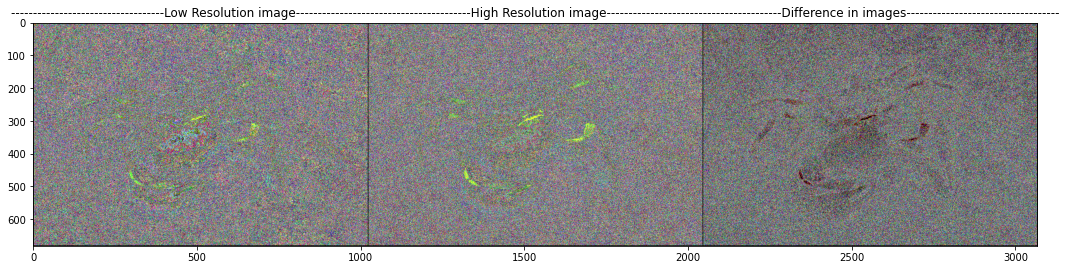

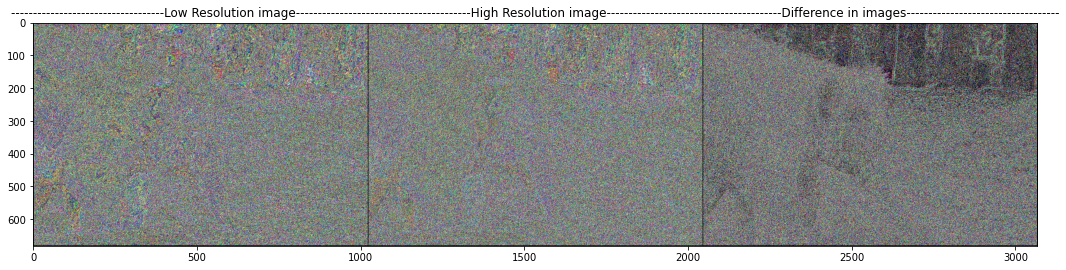

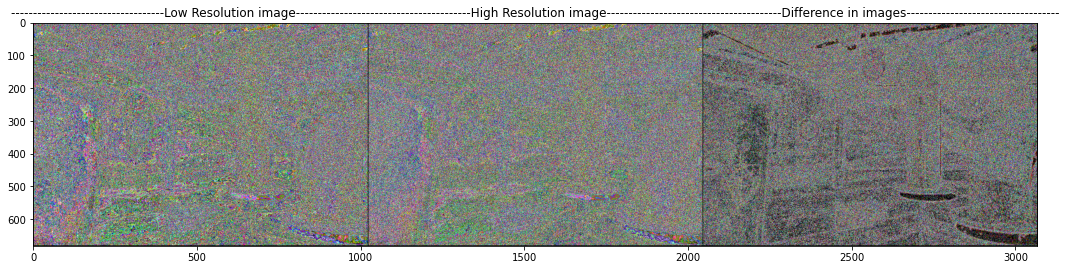

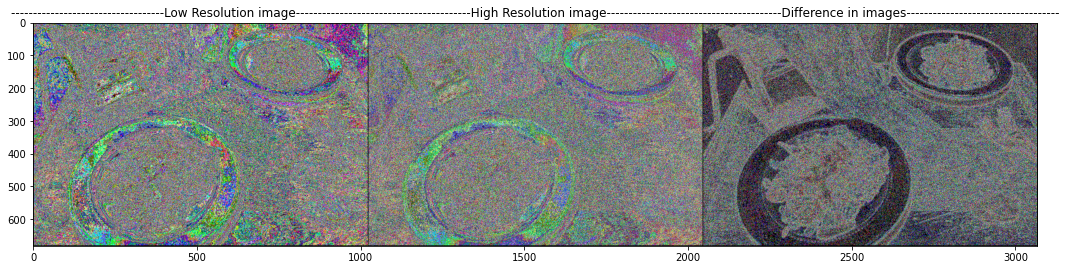

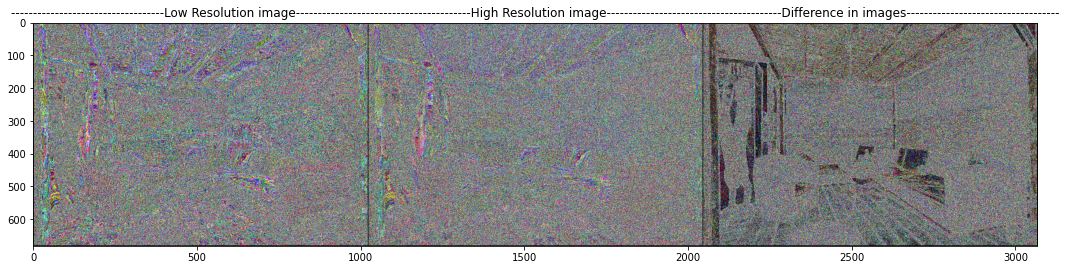

In [5]:
visualize_random_images(train_data)

In [6]:
class Trainer:
    def __init__(self, train_dataloader, valid_dataloader, config):
        self.patience = 5
        self.config = config
        self.model = VDSR_Net(in_channels=self.config.INPUT_CHANNELS, 
                              out_channels=self.config.OUTPUT_CHANNELS, depth=self.config.DEPTH)
        self.loss_function = self.config.LOSS_CXE
        self.batch_size = self.config.BATCH_SIZE
        self.train_dataloader = train_dataloader
        self.valid_dataloader = valid_dataloader
        self.device = self.config.DEVICE
        self.epochs = self.config.EPOCHS
        self.lr = self.config.LEARNING_RATE
        self.optim_step_size = self.config.OPTIM_STEP_SIZE
        self.optim_gamma = self.config.OPTIM_GAMMA
        self.grad_clip_max_norm = self.config.GRAD_CLIP_MAX_NORM
        self.momentum=self.config.MOMENTUM
        self.weight_decay=self.config.WEIGHT_DECAY
        self.evaluation_metric = self.config.EVALUATION_METRIC
        self.device = self.config.DEVICE
        self.val_for_early_stopping = 9999999 #early stopping
        
        if not os.path.isdir(self.config.MODEL_SAVEPATH):
            os.makedirs(self.config.MODEL_SAVEPATH)
        
        self.log = pd.DataFrame(columns=["model_name", "train_loss", "train_PSNR", "valid_loss", "valid_PSNR"])
        self.optimizer = optim.SGD(params=self.model.parameters(), 
                                   lr=self.lr, 
                                   momentum=self.momentum,
                                   weight_decay=self.weight_decay)
        self.optim_scheduler = optim.lr_scheduler.StepLR(self.optimizer, 
                                      step_size=self.optim_step_size,
                                      gamma=self.optim_gamma)
    
    def calculate_metrics(self, dataloader):
        self.model.eval()
        total_loss = 0
        total_performance = 0
        with torch.no_grad():
            for lr_image, hr_image, _ in tqdm(dataloader, total=len(dataloader)):
                low_res_image = lr_image.to(self.device)
                high_res_image = hr_image.to(self.device)
                out = self.model(low_res_image)
                loss = self.loss_function(out.data, high_res_image)
                total_loss += loss.item()
                total_performance += self.evaluation_metric(out.data.to("cpu"), high_res_image.cpu())
        return total_performance/len(dataloader), total_loss/len(dataloader)
    
    
    def early_stopping(self, val_loss):
        if val_loss < self.val_for_early_stopping:
            self.val_for_early_stopping = val_loss
            return True
        else:
            self.patience -= 1
            return False
    
    
    def fit(self):
        print("-"*25, "THE MODEL BASED ON" , self.config.ARCHITECTURE, "BEGINS TRAINING", "-"*25)
        print(f"TRAINING ON {self.config.DEVICE.upper()}")
        
        best_loss = 9e+6
        
        for epoch in range(self.epochs):
            self.model.train()
            self.model.to(self.device)
            log_file = open(f"log_epoch_{epoch}.txt", "a")
            log_messages = ""
            
            performance_train = 0
            loss_train = 0
            b_num = 0
            
            for lr_image, hr_image, res_diff in tqdm(self.train_dataloader, total=len(self.train_dataloader)):
                
                low_res_batch = lr_image.to(self.device)
                high_res_image = hr_image.to(self.device)
                self.optimizer.zero_grad()
                output = self.model(low_res_batch)
                loss = self.loss_function(output, high_res_image)
                loss.backward()
                self.optimizer.step()
                nn.utils.clip_grad_norm_(self.model.parameters(), self.grad_clip_max_norm)
                loss_train += loss.item()
                performance_train += self.evaluation_metric(output.data.to("cpu"), hr_image.to("cpu"))
                log_messages += f"LOSS, Performance at batch {b_num} after epoch {epoch}: {loss_train} : {performance_train}\n"
                b_num += 1
            
            self.optim_scheduler.step()
            
            log_file.write(log_messages)
            log_file.close()
            
            performance_valid, loss_valid = self.calculate_metrics(self.valid_dataloader)
            performance_train /= len(self.train_dataloader)
            loss_train /= len(self.train_dataloader)
            
            print("-"*10, "STATUS AT EPOCH NO.", epoch, "-"*10)
            print(f"Train performance : {performance_train}, Train loss {loss_train}")
            print(f"Valid performance : {performance_valid}, valid loss {loss_valid}")
            
            self.log.loc[epoch,:] = [f"{self.config.ARCHITECTURE}_{self.config.BATCH_SIZE}.pth", 
                                     f"{loss_train}",
                                     f"{performance_train}",
                                     f"{loss_valid}",
                                     f"{performance_valid}"]
            self.log.to_csv(self.config.MODEL_SAVEPATH + 
                            f"/{self.config.ARCHITECTURE}_{self.config.BATCH_SIZE}_valid_{epoch}.csv",index=False)
            
            if self.patience >= 0 and self.early_stopping(loss_valid):
                print(f"Saving model at Epoch: {epoch}")
                torch.save(self.model.state_dict(), self.config.MODEL_SAVEPATH + "/" +
                           f"{self.config.ARCHITECTURE}_{self.config.BATCH_SIZE}.pth")
                self.patience = 5
            
            if self.patience <= 0:
                print("-"*10, "EARLY STOPPING", "-"*10)
                print("Training terminated, no improvement in valid loss")
                break


In [6]:
config = Configuration()
print(config)
best_loss = 9e+15
model = VDSR_Net(depth=config.DEPTH)
optimizer = optim.SGD(params=model.parameters(), 
                                   lr=config.LEARNING_RATE, 
                                   momentum=config.MOMENTUM,
                                   weight_decay=config.WEIGHT_DECAY)
optim_scheduler = optim.lr_scheduler.StepLR(optimizer, 
                                      step_size=config.OPTIM_STEP_SIZE,
                                      gamma=config.OPTIM_GAMMA)

train_data = StandardDataset("./Flickr2K_train.csv")
valid_data = StandardDataset("./Flickr2K_valid.csv")

train_dataloader = DataLoader(train_data, batch_size=config.BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(valid_data, batch_size=2, shuffle=True)

loss_function = nn.MSELoss()
epoch_number = 0
model.to(config.DEVICE)

# The training loop
for epoch in range(config.EPOCHS):
    # print("-"*30 + f" EPOCH {epoch} " + "-"*30)
    model.train(True)
    running_loss = 0
    last_loss = 0
    batch_index = 0
    
    for lr_image, hr_image, res_image in tqdm(train_dataloader, total=len(train_dataloader)):
        low_res_batch = lr_image.to(config.DEVICE)
        high_res_batch = hr_image.to(config.DEVICE)
        
        optimizer.zero_grad()
        outputs = model(low_res_batch)
        
        loss = loss_function(outputs, high_res_batch)
        loss.backward()
        
        # Adjust learning weights
        optimizer.step()
        running_loss += loss.item()
        if batch_index == len(train_dataloader) - 1:
            last_loss = running_loss / len(train_dataloader)
            print(f'  batch {batch_index} loss: {last_loss}')
            running_loss = 0
        
    avg_loss = last_loss
    print(f"Loss after epoch {epoch} is {running_loss}")
    
#     running_vloss = 0.0
    
#     for i, vdata in enumerate(validation_loader):
#         vinputs, vlabels, _ = vdata
#         vinputs, vlabels = vinputs.to(config.DEVICE), vlabels.to(config.DEVICE)
#         voutputs = model(vinputs)
#         vloss = loss_function(voutputs, vlabels)
#         running_vloss += vloss

#     avg_vloss = running_vloss / (i + 1)
#     print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
#     optim_scheduler.step()
    
#     if avg_vloss < best_vloss:
#         best_vloss = avg_vloss
#         model_path = 'models/model_{}_{}'.format(timestamp, epoch_number)
#         torch.save(model.state_dict(), model_path)

    epoch_number += 1

---------------------------------------- CONFIGURATION DETAILS ----------------------------------------
Architecture : VDSR-Net
Batch Size : 4
Number of Input Channels : 3
Number of Output Channels : 3
Depth of the network : 10
Training platform : CUDA
Number of epochs : 80
Gradient clipping with max norm : 0.01
Loss Function : MSE Loss
Performance metric : Peak Signal To Noise Ratio (PSNR)
----------------------------------------------------------------------------------------------------------


100%|██████████| 188/188 [02:49<00:00,  1.11it/s]


Loss after epoch 0 is nan


  4%|▎         | 7/188 [00:07<03:07,  1.04s/it]


KeyboardInterrupt: 

In [7]:
def main(config, n_images_to_viz=0):
    train_data = StandardDataset("./Flickr2K_train.csv")
    valid_data = StandardDataset("./Flickr2K_valid.csv")
    if(n_images_to_viz):
        visualize_random_number_of_images(train_data, n_images_to_viz)
    train_dataloader = DataLoader(train_data, batch_size=vdsr_config.BATCH_SIZE, shuffle=True)
    valid_dataloader = DataLoader(valid_data, batch_size=vdsr_config.BATCH_SIZE, shuffle=True)
    
    trainer = Trainer(train_dataloader, valid_dataloader, config)
    trainer.fit()

In [8]:
vdsr_config = Configuration()
print(vdsr_config)

---------------------------------------- CONFIGURATION DETAILS ----------------------------------------
Architecture : VDSR-Net
Batch Size : 4
Number of Input Channels : 3
Number of Output Channels : 3
Depth of the network : 10
Training platform : CUDA
Number of epochs : 80
Gradient clipping with max norm : 0.01
Loss Function : CXE Loss
Performance metric : Peak Signal To Noise Ratio (PSNR)
----------------------------------------------------------------------------------------------------------


In [9]:
main(vdsr_config)

------------------------- THE MODEL BASED ON VDSR-Net BEGINS TRAINING -------------------------
TRAINING ON CUDA


100%|██████████| 13/13 [00:17<00:00,  1.37s/it]


---------- STATUS AT EPOCH NO. 0 ----------
Train performance : nan, Train loss nan
Valid performance : nan, valid loss nan


100%|██████████| 13/13 [00:06<00:00,  2.00it/s]


---------- STATUS AT EPOCH NO. 1 ----------
Train performance : nan, Train loss nan
Valid performance : nan, valid loss nan


100%|██████████| 13/13 [00:06<00:00,  1.99it/s]


---------- STATUS AT EPOCH NO. 2 ----------
Train performance : nan, Train loss nan
Valid performance : nan, valid loss nan


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


---------- STATUS AT EPOCH NO. 3 ----------
Train performance : nan, Train loss nan
Valid performance : nan, valid loss nan


100%|██████████| 13/13 [00:06<00:00,  2.00it/s]

---------- STATUS AT EPOCH NO. 4 ----------
Train performance : nan, Train loss nan
Valid performance : nan, valid loss nan
---------- EARLY STOPPING ----------
Training terminated, no improvement in valid loss
